In [23]:
from mueller_matrices import M_Retarder, M_Diattenuator, M_rotate, M_LinearPolarizer, stokes2ellipse
from plotting import plotEllipse, plotEllipseStokes
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [57]:
def M_inst_e(e):
    M = sp.Matrix([[1, 0, 0, -1],
                  [1, np.cos(2*np.arctan(e)), 0, -np.sin(2*np.arctan(e))],
                  [1, -0.5*np.cos(2*np.arctan(e)), np.sqrt(3)/2*np.cos(2*np.arctan(e)), -np.sin(2*np.arctan(e))],
                  [1, -0.5*np.cos(2*np.arctan(e)), -np.sqrt(3)/2*np.cos(2*np.arctan(e)), -np.sin(2*np.arctan(e))]])
                   
    return M

def M_inst_swing(chi):
    M = sp.Matrix([[1, 0, 0, -1],
                  [1, np.sin(2*np.pi*chi), 0, -np.cos(2*np.pi*chi)],
                  [1, -0.5*np.sin(2*np.pi*chi), np.sqrt(3)*np.cos(np.pi*chi)*np.sin(np.pi*chi), -np.cos(2*np.pi*chi)],
                  [1, -0.5*np.sin(2*np.pi*chi), -np.sqrt(3)/2*np.sin(2*np.pi*chi), -np.cos(2*np.pi*chi)]])
                   
    return M

def S_spec(t, p, slow, ret):
    S = sp.Matrix([[t],
                  [t*p*np.sin(2*slow)*np.sin(ret)],
                  [-t*p*np.cos(2*slow)*np.sin(ret)],
                  [t*p*np.cos(ret)]])
    return S

def genStarTarget(N, M, blur_px = 2, margin=60):
    '''
    generate Siemens star for simulation target
    Input:
        (N, M)  : (y, x) dimension of the simulated image
        blur_px : degree of the blurring imposed on the generated image
    Output:
        star    : Siemens star with the size of (N, M)
        theta   : polar angle np array with the size of (N, M)
    '''
    # Construct Siemens star
    x = np.r_[:N]-N//2
    y = np.r_[:M]-M//2
    xx, yy = np.meshgrid(x,y)
    rho = np.sqrt(xx**2 + yy**2)
    theta = np.arctan2(yy, xx)
    # star = (1 + np.cos(40*theta))
    # star = np.pad(star[10:-10,10:-10],(10,),mode='constant')
    star = (1 + np.cos(16*theta))
    star = np.pad(star[margin:-margin,margin:-margin],(margin,),mode='constant')
    star[star<1] = 0
    # Filter to prevent aliasing
    Gaussian = np.exp(-rho**2/(2*blur_px**2))
    star = np.maximum(0, np.real(np.fft.ifft2(np.fft.fft2(star) * np.fft.fft2(np.fft.ifftshift(Gaussian)))))
    # star = np.maximum(0, np.real(ifft2(fft2(star) * fft2(ifftshift(Gaussian)))))*(2+np.sin(2*np.pi*(1/5)*rho))
    star /= np.max(star)
    
    return star, theta, xx

In [81]:
N = 400
M = 400
star, theta, xx = genStarTarget(N,M, blur_px=1)

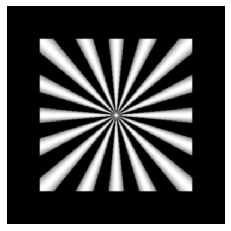

In [82]:
plt.imshow(star, 'gray')
plt.axis('off')
plt.show()

In [83]:
x = M_inst_swing(.5) * S_spec(1,1,1,1)
x.shape

(4, 1)

In [84]:
%%time

# inten = np.zeros([4,1,2048,2048])
I_lcp = np.zeros([N,M])
I_0 = np.zeros([N,M])
I_60 = np.zeros([N,M])
I_120 = np.zeros([N,M])
swing = 0.03

t = np.ones(xx.shape)
p = np.ones(xx.shape)

for i in range(N):
    for j in range(M):
        s = M_inst_swing(swing) * S_spec(t[i,j], p[i,j], theta[i,j], star[i,j])
        I_lcp[i,j] = s[0]
        I_0[i,j] = s[1]
        I_60[i,j] = s[2]
        I_120[i,j] = s[3]
#         inten[:,i,j] = M_inst_swing(swing) * S_spec(t[i,j], p[i,j], theta[i,j], star[i,j])

CPU times: user 1min 48s, sys: 486 ms, total: 1min 49s
Wall time: 1min 49s


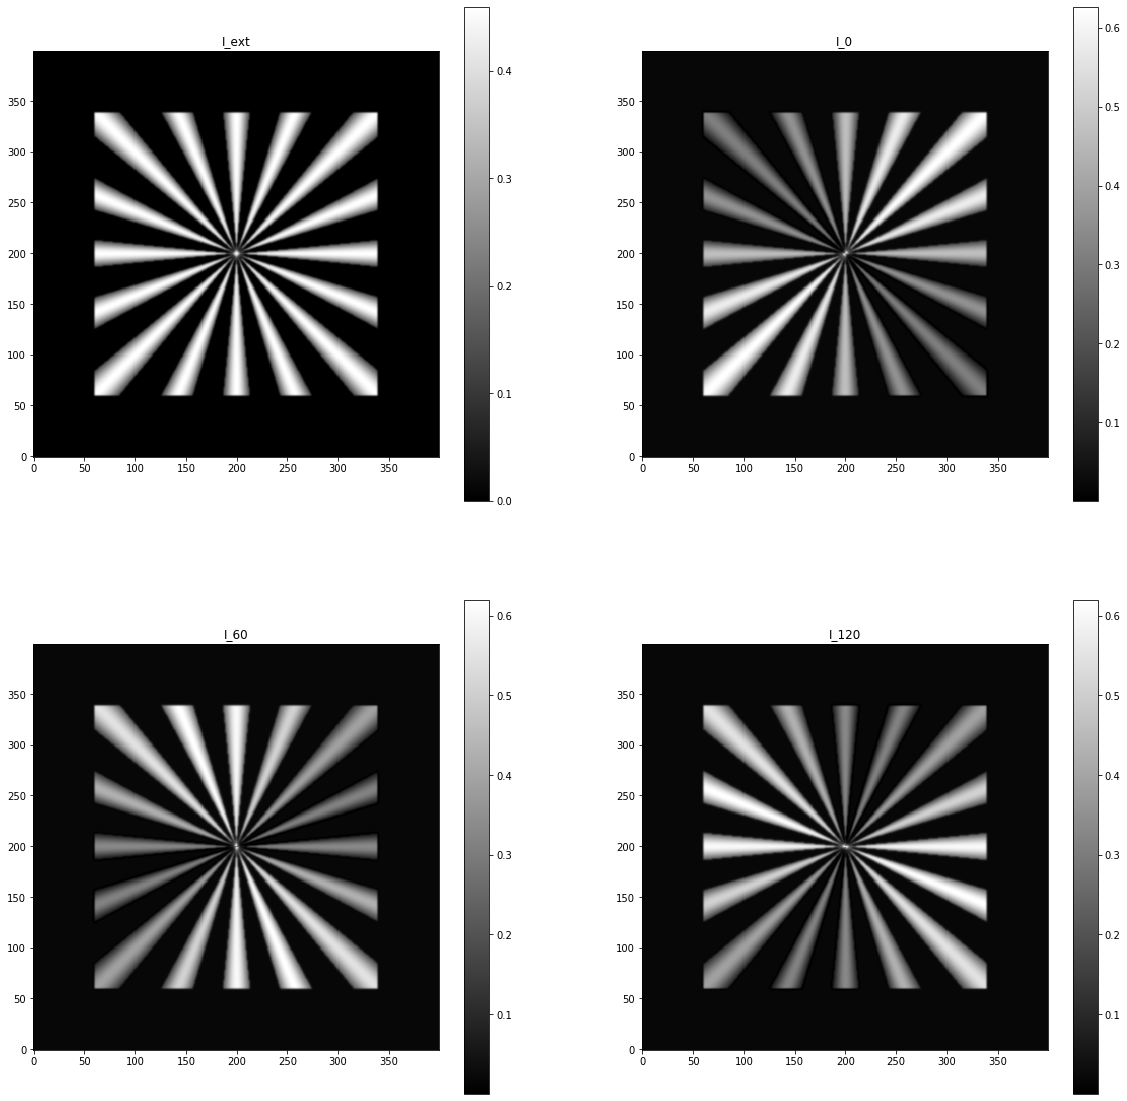

In [85]:
fig1 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
im=plt.imshow(I_lcp,cmap='gray', origin='lower');
plt.title('I_ext')
ax1.figure.colorbar(im);

ax2=fig1.add_subplot(2,2,2)
im=plt.imshow(I_0,cmap='gray', origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('I_0')
ax2.figure.colorbar(im);

ax3=fig1.add_subplot(2,2,3)
im=plt.imshow(I_60,cmap='gray', origin='lower');
plt.title('I_60')
ax3.figure.colorbar(im);

ax4=fig1.add_subplot(2,2,4)
im=plt.imshow(I_120,cmap='gray', origin='lower');
plt.title('I_120')
ax4.figure.colorbar(im);

In [2]:
#LCP
M_analyzer = sp.Matrix([[1, 0, 0, -1],
                        [0, 0, 0, 0],
                        [0, 0, 0, 0],
                        [-1, 0, 0, 1]])/2

M_analyzerVert = sp.Matrix([[1, 1, 0, 0],
                            [1, 1, 0, 0],
                            [0, 0, 0, 0],
                            [0, 0, 0, 0]])

M_horiz_pol = sp.Matrix([[1,-1,0,0],
                         [-1,1,0,0],
                         [0, 0, 0, 0],
                         [0, 0, 0, 0]])

M_lin_45 = M_rotate(M_analyzerVert, np.pi/4)
M_lin_90 = M_rotate(M_analyzerVert, np.pi/2)
M_lin_135 = M_rotate(M_analyzerVert, 3*np.pi/4)

M_60 = M_rotate(M_analyzerVert, -np.pi/3)
M_120 = M_rotate(M_analyzerVert, -2*np.pi/3)

In [ ]:

swing = 0.03
lca_swing = np.sqrt(swing/2.793)
lcb_swing = 1.8*lca_swing
print(lca_swing,lcb_swing)

deg60 = [0.25-lca_swing, 0.5+lcb_swing]
deg120 = [0.25-lca_swing, 0.5-lcb_swing]
deg0 = [0.2800000000000001, 0.5]
deg45 = [0.25, 0.53]
deg135 = [0.25, 0.47]
deg90 = [0.22,0.5]
degExt = [0.25, 0.5]
swing = 0.03

S_in = sp.Matrix([1, -1, 0, 0])

S0_0 = np.zeros(360)
S0_60 = np.zeros(360)
S0_120 = np.zeros(360)

S0_45 = np.zeros(360)
S0_135 = np.zeros(360)
S0_0 = np.zeros(360)
S0_90 = np.zeros(360)
S0_ext = np.zeros(360)


j = 0
for i in range():
#     M_lin = M_rotate(M_horiz_pol,i)
    M_uni_0 = M_Retarder(theta=0, delta = deg0[1]*2*np.pi) * M_Retarder(theta=np.pi/4, delta = deg0[0]*2*np.pi)
    M_uni_60 = M_Retarder(theta=0, delta = deg60[1]*2*np.pi) * M_Retarder(theta=np.pi/4, delta = deg60[0]*2*np.pi)
    M_uni_120 = M_Retarder(theta=0, delta = deg120[1]*2*np.pi) * M_Retarder(theta=np.pi/4, delta = deg120[0]*2*np.pi)
    
    M_uni_ext = M_Retarder(theta=0, delta = degExt[1]*2*np.pi) * M_Retarder(theta=np.pi/4, delta = degExt[0]*2*np.pi)
    M_uni_45 = M_Retarder(theta=0, delta = deg45[1]*2*np.pi) * M_Retarder(theta=np.pi/4, delta = deg45[0]*2*np.pi)
    M_uni_90 = M_Retarder(theta=0, delta = deg90[1]*2*np.pi) * M_Retarder(theta=np.pi/4, delta = deg90[0]*2*np.pi)
    M_uni_135 = M_Retarder(theta=0, delta = deg135[1]*2*np.pi) * M_Retarder(theta=np.pi/4, delta = deg135[0]*2*np.pi)
    
#     S_out_0 = M_analyzer * M_lin * M_uni_0 * S_in
#     S_out_60 = M_analyzer * M_lin * M_uni_60 * S_in
#     S_out_120 = M_analyzer * M_lin * M_uni_120 * S_in
    
#     S_out_ext = M_analyzer * M_lin * M_uni_ext * S_in
#     S_out_45 = M_analyzer * M_lin * M_uni_45 * S_in
#     S_out_90 = M_analyzer * M_lin * M_uni_90 * S_in
#     S_out_135 = M_analyzer * M_lin * M_uni_135 * S_in
    
    S_out_0 =  M_lin * M_uni_0 * S_in
    S_out_60 = M_lin * M_uni_60 * S_in
    S_out_120 = M_lin * M_uni_120 * S_in
    
    S_out_ext = M_lin * M_uni_ext * S_in
    S_out_45 = M_lin * M_uni_45 * S_in
    S_out_90 = M_lin * M_uni_90 * S_in
    S_out_135 = M_lin * M_uni_135 * S_in
    
    S0_ext[j] = S_out_ext[0]
    S0_45[j] = S_out_45[0]
    S0_90[j] = S_out_90[0]
    S0_135[j] = S_out_135[0]
    
    S0_0[j] = S_out_0[0]
    S0_60[j] = S_out_60[0]
    S0_120[j] = S_out_120[0]
    j += 1